# DeepOilFlow: LSTM-powered oil production forecasting using temporal well data analysis

This project designs an AI deep learning system to predict future oil production rates for petroleum wells using historical production data. 

The implementation includes advanced features such as:
- Early stopping to prevent overfitting
- Learning rate scheduling
- SHAP (SHapley Additive exPlanations) analysis
- And much more!

The SHAP analysis presents us with interpretable insights into which production parameters influence future oil rates. 

This transparency is crucial for geologists to validate the model's predictions relative to domain knowledge.

__Github Link__: https://github.com/tiagomonteiro0715/DeepOilFlow

# Importing libraries

In [1]:
import json
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap
import torch
import torch.nn as nn
from IPython.display import HTML, display
from torch.utils.data import DataLoader, Dataset, random_split

# Data source

__Dataset:__ https://researchportal.hw.ac.uk/en/datasets/costa-model-hierarchical-carbonate-reservoir-benchmarking-case-st

__Article explaining the dataset:__ https://researchportal.hw.ac.uk/en/publications/the-design-of-an-open-source-carbonate-reservoir-model

The "COSTA Synthetic Production Monthly" excel file from 5-production provides 30 years of production data from 248 wells. 

It is partially synthetic, anonymized, carbonate-specific, from a single hidden-truth field with artificial noise.

While it may not reflect all real-world complexities, it offers significant advantages: 

1. Realistic
2. Well-documented data ideal for learning temporal patterns
3. Testing prediction models without confidentiality concerns

The truth case ensures physics-governed data without gaps.

## Target variableand its economic value

Oil Rate SC - Monthly (bbl/day)

Predicting oil rate directly determines profitability and investment decisions.

## 1º step of data processing: removing yellow headers on each sheet and "charts" sheet

From the file "COSTA Synthetic Production Monthly", we manually create a new file called "final_dataset.xlsx"

We essencially remove the *yellow headers on each sheet* so that python can process the file. Otherwise it is impossible for python to process.

We alsp remove the charts sheet since it is of no use.

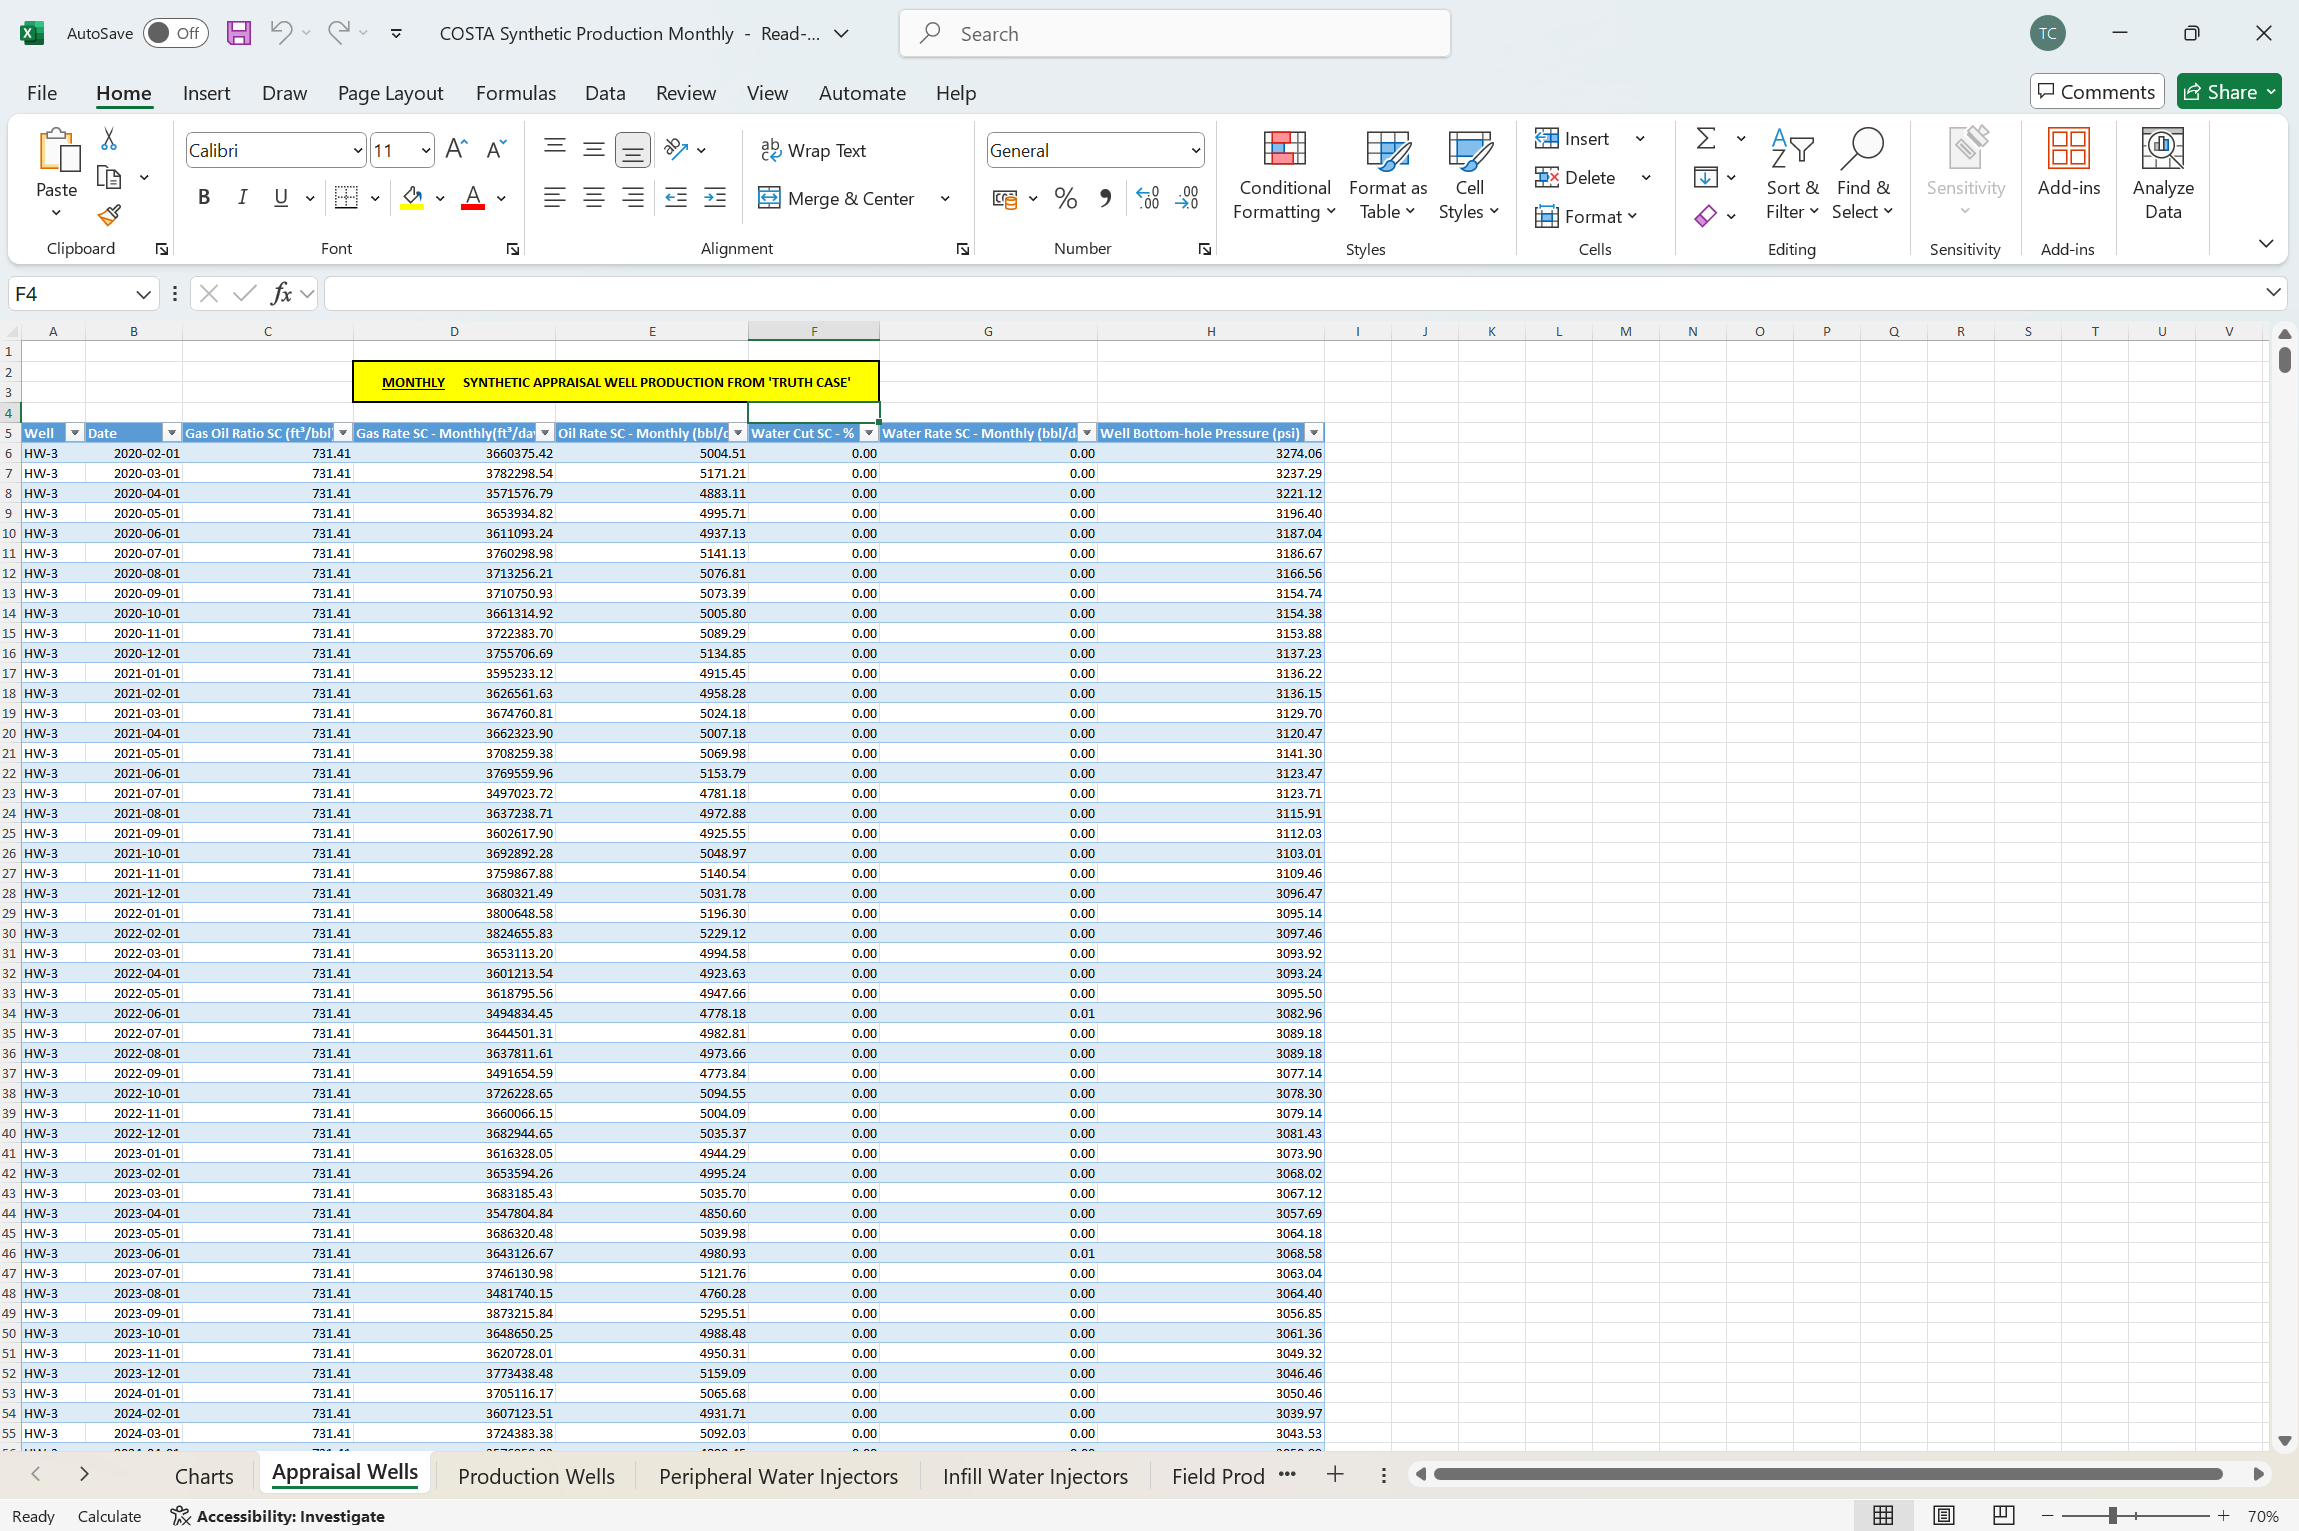

From this, we create a new excel file called final_dataset.xlsx

## 2º step of data processing: Converting the data to be used by a machine learning model

### First we are going to analyse the dataset of Production Wells

In [2]:
excel_file = pd.ExcelFile('final_dataset.xlsx')
all_sheets = {sheet: pd.read_excel(excel_file, sheet_name=sheet) for sheet in excel_file.sheet_names}

df_sheet2 = all_sheets['Production Wells'].iloc[4:]

print(f" Loaded Production Wells data")
print(f"  Total rows: {len(df_sheet2):,}")
print(f"  Total unique wells: {df_sheet2['Well'].nunique()}")

print("Columns:")
for column in list(df_sheet2.columns):
    print(column)

 Loaded Production Wells data
  Total rows: 47,868
  Total unique wells: 248
Columns:
Well
Date
Gas Oil Ratio SC (ft³/bbl)
Gas Rate SC - Monthly (ft³/day)
Oil Rate SC - Monthly (bbl/day)
Water Cut SC - %
Water Rate SC - Monthly (bbl/day)
Well Bottom-hole Pressure (psi)


For simplification, since it is the one with most data, the production wells sheet is the main one we are going to preprocess to use for the creation of a machine learning model.

### Analyse the data

In [3]:
print(f"Total unique wells: {df_sheet2['Well'].nunique()}")
print("\nFrequency of frequencies (how many wells appear X times):")
print(df_sheet2['Well'].value_counts().value_counts().sort_index(ascending=False))

Total unique wells: 248

Frequency of frequencies (how many wells appear X times):
count
300     8
288     8
276     8
264     8
252     8
240    16
228    16
216    16
204    18
192    21
180    21
168    20
156    20
144    20
132    20
120    20
Name: count, dtype: int64


It has 8 wells with 300 rows of data

It has 8 wells with 288 rows of data

It has 8 wells with 276 rows of data

.
.
.


It has 20 wells with 120 rows of data


### Create a sliding window function to process all wells informations to be used by an machine learning model

Since the data in each well is distributed by row in a temporal way, we are going to change that to be distributed by collumn.

This way, we can reformat the dataset in a way the machine learning model can learn the temporal differences between feature data to better predict the target variable.

In [4]:
WINDOW_SIZE = 12
TARGET_HORIZON = 1

print(f"Window size: {WINDOW_SIZE} months | Target horizon: {TARGET_HORIZON} month ahead\n")

def create_sliding_windows(df, well_name, window_size=12):
    """Create sliding window samples for a single well"""
    df = df.reset_index(drop=True)
    
    if len(df) < window_size + 1:
        return []
    
    samples = []
    for i in range(len(df) - window_size):
        sample = {'Well': well_name, 'Target_Oil_Rate': df.iloc[i + window_size]['Oil Rate SC - Monthly (bbl/day)']}
        
        for month in range(1, window_size + 1):
            for col in df.columns:
                if col != 'Well':
                    sample[f'Month_{month}_{col}'] = df.iloc[i + month - 1][col]
        
        samples.append(sample)
    
    return samples

Window size: 12 months | Target horizon: 1 month ahead



## We apply the sliding window function to create a new dataset

In [5]:
all_samples = []
total_wells = df_sheet2['Well'].nunique()

for idx, (well_name, well_data) in enumerate(df_sheet2.groupby('Well'), 1):
    all_samples.extend(create_sliding_windows(well_data, well_name, WINDOW_SIZE))
    
    if idx % 4 == 0:
        print(f"Progress: {idx}/{total_wells} wells ({idx/total_wells*100:.1f}%) - {len(all_samples):,} samples")

print(f"Progress: {total_wells}/{total_wells} wells (100.0%) - {len(all_samples):,} samples total")

Progress: 4/248 wells (1.6%) - 948 samples
Progress: 8/248 wells (3.2%) - 1,716 samples
Progress: 12/248 wells (4.8%) - 2,448 samples
Progress: 16/248 wells (6.5%) - 3,264 samples
Progress: 20/248 wells (8.1%) - 3,984 samples
Progress: 24/248 wells (9.7%) - 4,800 samples
Progress: 28/248 wells (11.3%) - 5,520 samples
Progress: 32/248 wells (12.9%) - 6,240 samples
Progress: 36/248 wells (14.5%) - 7,020 samples
Progress: 40/248 wells (16.1%) - 7,692 samples
Progress: 44/248 wells (17.7%) - 8,364 samples
Progress: 48/248 wells (19.4%) - 9,144 samples
Progress: 52/248 wells (21.0%) - 9,816 samples
Progress: 56/248 wells (22.6%) - 10,476 samples
Progress: 60/248 wells (24.2%) - 11,220 samples
Progress: 64/248 wells (25.8%) - 11,844 samples
Progress: 68/248 wells (27.4%) - 12,588 samples
Progress: 72/248 wells (29.0%) - 13,212 samples
Progress: 76/248 wells (30.6%) - 13,836 samples
Progress: 80/248 wells (32.3%) - 14,544 samples
Progress: 84/248 wells (33.9%) - 15,120 samples
Progress: 88/24

## We export the dataset

In [6]:
df_windowed = pd.DataFrame(all_samples)
cols = ['Well', 'Target_Oil_Rate'] + [c for c in df_windowed.columns if c not in ['Well', 'Target_Oil_Rate']]
df_windowed = df_windowed[cols]

output_filename = 'production_wells_sliding_window.csv'
df_windowed.to_csv(output_filename, index=False)

## Dataset before sliding window

In [7]:
display(HTML(df_sheet2.head(100).to_html()))

,Well,Date,Gas Oil Ratio SC (ft³/bbl),Gas Rate SC - Monthly (ft³/day),Oil Rate SC - Monthly (bbl/day),Water Cut SC - %,Water Rate SC - Monthly (bbl/day),Well Bottom-hole Pressure (psi)
4,Well-1,2025-02-01,731.414978,3.567828e+06,4877.981171,0.000046,0.002222,3132.787350
5,Well-1,2025-03-01,731.414978,3.662807e+06,5007.836862,0.000064,0.003183,3090.725933
6,Well-1,2025-04-01,731.414978,3.626329e+06,4957.963500,0.000050,0.002470,3059.375781
7,Well-1,2025-05-01,731.414978,3.740978e+06,5114.712817,0.000048,0.002431,3039.715643
8,Well-1,2025-06-01,731.414978,3.657319e+06,5000.333284,0.000051,0.002528,3015.697719
9,Well-1,2025-07-01,731.414978,3.592993e+06,4912.386022,0.000103,0.005059,3003.678545
10,Well-1,2025-08-01,731.414978,3.680401e+06,5031.892153,0.000070,0.003539,2986.926955
11,Well-1,2025-09-01,731.414978,3.593829e+06,4913.529550,0.000067,0.003279,2968.007638
12,Well-1,2025-10-01,731.414978,3.534131e+06,4831.909593,0.000108,0.005200,2947.988424
13,Well-1,2025-11-01,731.414978,3.603630e+06,4926.930069,0.000124,0.006090,2923.813792


## Dataset after sliding window

In [8]:
display(HTML(df_windowed.head(100).to_html()))

,Well,Target_Oil_Rate,Month_1_Date,Month_1_Gas Oil Ratio SC (ft³/bbl),Month_1_Gas Rate SC - Monthly (ft³/day),Month_1_Oil Rate SC - Monthly (bbl/day),Month_1_Water Cut SC - %,Month_1_Water Rate SC - Monthly (bbl/day),Month_1_Well Bottom-hole Pressure (psi),Month_2_Date,Month_2_Gas Oil Ratio SC (ft³/bbl),Month_2_Gas Rate SC - Monthly (ft³/day),Month_2_Oil Rate SC - Monthly (bbl/day),Month_2_Water Cut SC - %,Month_2_Water Rate SC - Monthly (bbl/day),Month_2_Well Bottom-hole Pressure (psi),Month_3_Date,Month_3_Gas Oil Ratio SC (ft³/bbl),Month_3_Gas Rate SC - Monthly (ft³/day),Month_3_Oil Rate SC - Monthly (bbl/day),Month_3_Water Cut SC - %,Month_3_Water Rate SC - Monthly (bbl/day),Month_3_Well Bottom-hole Pressure (psi),Month_4_Date,Month_4_Gas Oil Ratio SC (ft³/bbl),Month_4_Gas Rate SC - Monthly (ft³/day),Month_4_Oil Rate SC - Monthly (bbl/day),Month_4_Water Cut SC - %,Month_4_Water Rate SC - Monthly (bbl/day),Month_4_Well Bottom-hole Pressure (psi),Month_5_Date,Month_5_Gas Oil Ratio SC (ft³/bbl),Month_5_Gas Rate SC - Monthly (ft³/day),Month_5_Oil Rate SC - Monthly (bbl/day),Month_5_Water Cut SC - %,Month_5_Water Rate SC - Monthly (bbl/day),Month_5_Well Bottom-hole Pressure (psi),Month_6_Date,Month_6_Gas Oil Ratio SC (ft³/bbl),Month_6_Gas Rate SC - Monthly (ft³/day),Month_6_Oil Rate SC - Monthly (bbl/day),Month_6_Water Cut SC - %,Month_6_Water Rate SC - Monthly (bbl/day),Month_6_Well Bottom-hole Pressure (psi),Month_7_Date,Month_7_Gas Oil Ratio SC (ft³/bbl),Month_7_Gas Rate SC - Monthly (ft³/day),Month_7_Oil Rate SC - Monthly (bbl/day),Month_7_Water Cut SC - %,Month_7_Water Rate SC - Monthly (bbl/day),Month_7_Well Bottom-hole Pressure (psi),Month_8_Date,Month_8_Gas Oil Ratio SC (ft³/bbl),Month_8_Gas Rate SC - Monthly (ft³/day),Month_8_Oil Rate SC - Monthly (bbl/day),Month_8_Water Cut SC - %,Month_8_Water Rate SC - Monthly (bbl/day),Month_8_Well Bottom-hole Pressure (psi),Month_9_Date,Month_9_Gas Oil Ratio SC (ft³/bbl),Month_9_Gas Rate SC - Monthly (ft³/day),Month_9_Oil Rate SC - Monthly (bbl/day),Month_9_Water Cut SC - %,Month_9_Water Rate SC - Monthly (bbl/day),Month_9_Well Bottom-hole Pressure (psi),Month_10_Date,Month_10_Gas Oil Ratio SC (ft³/bbl),Month_10_Gas Rate SC - Monthly (ft³/day),Month_10_Oil Rate SC - Monthly (bbl/day),Month_10_Water Cut SC - %,Month_10_Water Rate SC - Monthly (bbl/day),Month_10_Well Bottom-hole Pressure (psi),Month_11_Date,Month_11_Gas Oil Ratio SC (ft³/bbl),Month_11_Gas Rate SC - Monthly (ft³/day),Month_11_Oil Rate SC - Monthly (bbl/day),Month_11_Water Cut SC - %,Month_11_Water Rate SC - Monthly (bbl/day),Month_11_Well Bottom-hole Pressure (psi),Month_12_Date,Month_12_Gas Oil Ratio SC (ft³/bbl),Month_12_Gas Rate SC - Monthly (ft³/day),Month_12_Oil Rate SC - Monthly (bbl/day),Month_12_Water Cut SC - %,Month_12_Water Rate SC - Monthly (bbl/day),Month_12_Well Bottom-hole Pressure (psi)
0,Well-1,5023.651982,2025-02-01,731.414978,3.567828e+06,4877.981171,0.000046,0.002222,3132.787350,2025-03-01,731.414978,3.662807e+06,5007.836862,0.000064,0.003183,3090.725933,2025-04-01,731.414978,3.626329e+06,4957.963500,0.000050,0.002470,3059.375781,2025-05-01,731.414978,3.740978e+06,5114.712817,0.000048,0.002431,3039.715643,2025-06-01,731.414978,3.657319e+06,5000.333284,0.000051,0.002528,3015.697719,2025-07-01,731.414978,3.592993e+06,4912.386022,0.000103,0.005059,3003.678545,2025-08-01,731.414978,3.680401e+06,5031.892153,0.000070,0.003539,2986.926955,2025-09-01,731.414978,3.593829e+06,4913.529550,0.000067,0.003279,2968.007638,2025-10-01,731.414978,3.534131e+06,4831.909593,0.000108,0.005200,2947.988424,2025-11-01,731.414978,3.603630e+06,4926.930069,0.000124,0.006090,2923.813792,2025-12-01,731.414978,3.648792e+06,4988.675921,0.000102,0.005107,2913.636242,2026-01-01,731.414978,3.766142e+06,5149.117544,0.000092,0.004745,2903.087513
1,Well-1,5156.666858,2025-03-01,731.414978,3.662807e+06,5007.836862,0.000064,0.003183,3090.725933,2025-04-01,731.414978,3.626329e+06,4957.963500,0.000050,0.002470,3059.375781,2025-05-01,731.41

# Training the new machine learning model

In [9]:
df = pd.read_csv('production_wells_sliding_window.csv')
df = df.drop(columns=[col for col in df.columns if 'Date' in col])
df = df.drop(columns=['Well'])
X = df.drop(columns=['Target_Oil_Rate'])
y = df['Target_Oil_Rate']

print(X.shape)
print(y.shape)

print(X.columns.to_list())

(44892, 72)
(44892,)
['Month_1_Gas Oil Ratio SC (ft³/bbl)', 'Month_1_Gas Rate SC - Monthly (ft³/day)', 'Month_1_Oil Rate SC - Monthly (bbl/day)', 'Month_1_Water Cut SC - %', 'Month_1_Water Rate SC - Monthly (bbl/day)', 'Month_1_Well Bottom-hole Pressure (psi)', 'Month_2_Gas Oil Ratio SC (ft³/bbl)', 'Month_2_Gas Rate SC - Monthly (ft³/day)', 'Month_2_Oil Rate SC - Monthly (bbl/day)', 'Month_2_Water Cut SC - %', 'Month_2_Water Rate SC - Monthly (bbl/day)', 'Month_2_Well Bottom-hole Pressure (psi)', 'Month_3_Gas Oil Ratio SC (ft³/bbl)', 'Month_3_Gas Rate SC - Monthly (ft³/day)', 'Month_3_Oil Rate SC - Monthly (bbl/day)', 'Month_3_Water Cut SC - %', 'Month_3_Water Rate SC - Monthly (bbl/day)', 'Month_3_Well Bottom-hole Pressure (psi)', 'Month_4_Gas Oil Ratio SC (ft³/bbl)', 'Month_4_Gas Rate SC - Monthly (ft³/day)', 'Month_4_Oil Rate SC - Monthly (bbl/day)', 'Month_4_Water Cut SC - %', 'Month_4_Water Rate SC - Monthly (bbl/day)', 'Month_4_Well Bottom-hole Pressure (psi)', 'Month_5_Gas Oil R

## Calculate and save in JSON file mean, std(standart deviation) for normalization

In [10]:
X_mean = X.mean(axis=0).values
X_std = X.std(axis=0).values
y_mean = y.mean()
y_std = y.std()

scaler_params = {
    "X_scaler": {
        "mean": X_mean.tolist(),
        "std": X_std.tolist(),
        "feature_names": X.columns.tolist()
    },
    "y_scaler": {
        "mean": float(y_mean),
        "std": float(y_std)
    }
}

with open('scaler_params.json', 'w') as f:
    json.dump(scaler_params, f, indent=2)
print("Scaler parameters saved to scaler_params.json")

Scaler parameters saved to scaler_params.json


# Data pre processing for LSTM use

## Creating a custom dataset class to pre process the data

The main reason for using a class to take care of the data is to ensure the data and its normalization logic is all together in one reusable object.

The class has 3 methods:
__init__: Sets up the dataset by storing your data and normalization parameters
__len__: Returns how many samples you have (needed by DataLoader)
__getitem__: Gets one normalized sample when requested by index (does the actual normalization)

This is one of the best ways in PyTorch to process data. It is simple and effective

In [11]:
class RegressionDataset(Dataset):
    def __init__(self, X, y, X_mean, X_std, y_mean, y_std):
        self.X = torch.FloatTensor(X.values if hasattr(X, 'values') else X)
        self.y = torch.FloatTensor(y.values if hasattr(y, 'values') else y)
        self.X_mean = torch.FloatTensor(X_mean)
        self.X_std = torch.FloatTensor(X_std)
        self.y_mean = torch.FloatTensor([y_mean])
        self.y_std = torch.FloatTensor([y_std])
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        #if self.X_std== 0, X normalized does not become Nan it becomes 1e-8
        X_normalized = (self.X[idx] - self.X_mean) / (self.X_std + 1e-8)
        y_normalized = (self.y[idx] - self.y_mean) / (self.y_std + 1e-8)
        return X_normalized, y_normalized

dataset = RegressionDataset(X, y, X_mean, X_std, y_mean, y_std)

### Examples of using the class

#### Using "__len__" special method

In [12]:
print(f"Dataset size: {len(dataset)}")

Dataset size: 44892


#### Using "__getitem__" special method

In [13]:
X_norm, y_norm = dataset[10]
print(f"Normalized X[10]: {X_norm}")
print(f"Normalized y[10]: {y_norm}")

Normalized X[10]: tensor([ 0.0000,  2.7563,  2.7563, -0.3438, -0.2397,  0.3240,  0.0000,  2.9098,
         2.9098, -0.3439, -0.2396,  0.3118,  0.0000,  2.8363,  2.8363, -0.3440,
        -0.2395,  0.2580,  0.0000,  2.9695,  2.9695, -0.3441, -0.2393,  0.2341,
         0.0000,  2.8577,  2.8577, -0.3442, -0.2392,  0.2128,  0.0000,  3.0329,
         3.0329, -0.3443, -0.2390,  0.1906,  0.0000,  2.8754,  2.8754, -0.3444,
        -0.2389,  0.1714,  0.0000,  2.8474,  2.8474, -0.3445, -0.2387,  0.1440,
         0.0000,  2.9190,  2.9190, -0.3446, -0.2386,  0.1351,  0.0000,  3.0256,
         3.0256, -0.3447, -0.2385,  0.0942,  0.0000,  2.9734,  2.9734, -0.3448,
        -0.2384,  0.0696,  0.0000,  3.1872,  3.1872, -0.3450, -0.2382,  0.0363])
Normalized y[10]: tensor([3.2182])


## Spliting dataset into training, developement(validation) and testing

In [14]:
total_size = len(dataset)
train_size = int(0.6 * total_size)
dev_size = int(0.2 * total_size)
test_size = total_size - train_size - dev_size

train_dataset, dev_dataset, test_dataset = random_split(
    dataset, 
    [train_size, dev_size, test_size],
    generator=torch.Generator().manual_seed(42)  # for reproducibility
)

print(f"Train size: {len(train_dataset)}, Dev size: {len(dev_dataset)}, Test size: {len(test_dataset)}")

Train size: 26935, Dev size: 8978, Test size: 8979


## Create the dataLoaders

DataLoaders automatically batch, shuffle, and load data in parallel. 

This way, making it easy to feed data to the model during training.

In [15]:
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Arquitecture of the LSTM model

I want to explain why the hidden network is the same for both LSTM and a standard neural network by chance. 

My intention was to use the Optuna library to improve the model right away and start simple. 

So, I decided no inicially have the hidden network the same for both the LSTM and the fully connected standart NN.

However, by chance, the initial results were very good!

So, using Optuna or a bigger architecture like xLSTM was discarded.

In [16]:
class LSTM_model(nn.Module):
    def __init__(self, input_size=6, hidden_size=128, num_layers=2, dropout=0.2, seq_length=12):
        super(LSTM_model, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout
        )
        
        self.fully_connected_block = nn.Sequential(
            nn.Linear(hidden_size, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, 32),
            nn.ReLU(),  # Added activation between layers
            nn.Linear(32, 1)
        )
        
    def forward(self, x):
        batch_size = x.size(0)
        x = x.view(batch_size, self.seq_length, -1)  # (batch_size, 12, 6)

        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        
        # LSTM forward pass
        lstm_out, (h_n, c_n) = self.lstm(x)
        
        # Use the last hidden state
        out = lstm_out[:, -1, :]  # (batch_size, hidden_size)
        
        # Fully connected layers
        out = self.fully_connected_block(out)
        
        return out

# Initializing LSTM model

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LSTM_model(
    input_size=6,      # 6 features per month
    hidden_size=128,   # LSTM hidden units
    num_layers=2,      # Number of LSTM layers
    dropout=0.2,       # Dropout rate
    seq_length=12      # 12 months
).to(device)

### Model architecture and total parameter count

In [18]:
print(model)
print(f"Total parameters: {sum(p.numel() for p in model.parameters())}")

LSTM_model(
  (lstm): LSTM(6, 128, num_layers=2, batch_first=True, dropout=0.2)
  (fully_connected_block): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ReLU()
    (5): Linear(in_features=32, out_features=1, bias=True)
  )
)
Total parameters: 212097


### Parameter names and shapes

In [19]:
for name, param in model.named_parameters():
    print(f"{name}: {param.shape}")

lstm.weight_ih_l0: torch.Size([512, 6])
lstm.weight_hh_l0: torch.Size([512, 128])
lstm.bias_ih_l0: torch.Size([512])
lstm.bias_hh_l0: torch.Size([512])
lstm.weight_ih_l1: torch.Size([512, 128])
lstm.weight_hh_l1: torch.Size([512, 128])
lstm.bias_ih_l1: torch.Size([512])
lstm.bias_hh_l1: torch.Size([512])
fully_connected_block.0.weight: torch.Size([64, 128])
fully_connected_block.0.bias: torch.Size([64])
fully_connected_block.3.weight: torch.Size([32, 64])
fully_connected_block.3.bias: torch.Size([32])
fully_connected_block.5.weight: torch.Size([1, 32])
fully_connected_block.5.bias: torch.Size([1])


### Direct children modules

In [20]:
for name, module in model.named_children():
    print(f"{name}: {module}")

lstm: LSTM(6, 128, num_layers=2, batch_first=True, dropout=0.2)
fully_connected_block: Sequential(
  (0): Linear(in_features=128, out_features=64, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=64, out_features=32, bias=True)
  (4): ReLU()
  (5): Linear(in_features=32, out_features=1, bias=True)
)


### All modules of the LSTM

In [21]:
for name, module in model.named_modules():
    print(f"{name}: {module}")

: LSTM_model(
  (lstm): LSTM(6, 128, num_layers=2, batch_first=True, dropout=0.2)
  (fully_connected_block): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ReLU()
    (5): Linear(in_features=32, out_features=1, bias=True)
  )
)
lstm: LSTM(6, 128, num_layers=2, batch_first=True, dropout=0.2)
fully_connected_block: Sequential(
  (0): Linear(in_features=128, out_features=64, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=64, out_features=32, bias=True)
  (4): ReLU()
  (5): Linear(in_features=32, out_features=1, bias=True)
)
fully_connected_block.0: Linear(in_features=128, out_features=64, bias=True)
fully_connected_block.1: ReLU()
fully_connected_block.2: Dropout(p=0.2, inplace=False)
fully_connected_block.3: Linear(in_features=64, out_features=32, bias=True)
fully_connected_block.4: ReLU()
fully_conn

## Hyperparameters, Loss function, optimizer and Learning rate scheduler

In [22]:
hyperparameters = {
    'learning_rate': 0.00001,
    'batch_size': 64,
    'num_epochs': 15,
    'weight_decay': 1e-5, 
    'patience': 5,  
    'min_delta': 1e-4 
}

print("\nHyperparameters:")
for key, value in hyperparameters.items():
    print(f"  {key}: {value}")

criterion = nn.MSELoss()

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=hyperparameters['learning_rate'],
    weight_decay=hyperparameters['weight_decay']
)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=10,
)


Hyperparameters:
  learning_rate: 1e-05
  batch_size: 64
  num_epochs: 15
  weight_decay: 1e-05
  patience: 5
  min_delta: 0.0001


# Functions to train the model

### Helper functions to simplify traning function

In [23]:
def print_epoch_progress(epoch, num_epochs, train_loss, dev_loss, patience_counter, patience):
    """Print progress for current epoch"""
    print(f'Epoch [{epoch+1:3d}/{num_epochs}] | '
          f'Train Loss: {train_loss:.6f} | '
          f'Dev Loss: {dev_loss:.6f} | '
          f'Patience: {patience_counter}/{patience}')


def print_training_summary(best_epoch, best_dev_loss, train_losses):
    """Print final training summary"""
    print("Training complete")
    print(f"Best Epoch: {best_epoch}")
    print(f"Best Dev Loss: {best_dev_loss:.6f}")
    print(f"Final Train Loss: {train_losses[best_epoch-1]:.6f}")

def train_one_epoch(model, train_loader, criterion, optimizer, device, train_dataset):
    """Train for one epoch and return average loss"""
    model.train()
    total_loss = 0.0
    
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        # Forward pass
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        total_loss += loss.item() * batch_X.size(0)
    
    return total_loss / len(train_dataset)  # Using __len__ from the RegressionDataset class


def validate(model, dev_loader, criterion, device, dev_dataset):
    """Validate model and return average loss"""
    model.eval()
    total_loss = 0.0
    
    with torch.no_grad():
        for batch_X, batch_y in dev_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            total_loss += loss.item() * batch_X.size(0)
    
    return total_loss / len(dev_dataset)  # Using __len__ from the RegressionDataset class

### Main tranining loop

In [24]:
def train_model(model, train_loader, dev_loader, criterion, optimizer, 
                scheduler, hyperparameters, device, train_dataset, dev_dataset):
    """Main training loop with early stopping"""
    # Extract hyperparameters
    num_epochs = hyperparameters['num_epochs']
    patience = hyperparameters['patience']
    min_delta = hyperparameters['min_delta']
    
    # Initialize tracking variables
    best_dev_loss = float('inf')
    best_epoch = 0
    patience_counter = 0
    train_losses = []
    dev_losses = []
    
    # Print header inline
    print("Starting Training \n")
    print(f"Device: {device}")
    print(f"Training samples: {len(train_dataset)}")
    print(f"Validation samples: {len(dev_dataset)}")
    print(f"Batches per epoch: {len(train_loader)}")
    
    # Training loop
    for epoch in range(num_epochs):
        # Train and validate
        train_loss = train_one_epoch(model, train_loader, criterion, optimizer, 
                                     device, train_dataset)
        dev_loss = validate(model, dev_loader, criterion, device, dev_dataset)
        
        # Store losses
        train_losses.append(train_loss)
        dev_losses.append(dev_loss)
        
        # Update learning rate
        scheduler.step(dev_loss)
        
        # Print progress
        print_epoch_progress(epoch, num_epochs, train_loss, dev_loss, 
                           patience_counter, patience)
        
        # Early stopping check
        if dev_loss < best_dev_loss - min_delta:
            improvement = best_dev_loss - dev_loss
            best_dev_loss = dev_loss
            best_epoch = epoch + 1
            patience_counter = 0
            
            torch.save(model.state_dict(), 'best_model.pth')
            print(f'> New best model saved | Improvement: {improvement:.6f}\n')
        else:
            patience_counter += 1
        
        # Check if should stop early
        if patience_counter >= patience:
            print(f'\n{"="*70}')
            print(f'Early stopping triggered after {epoch+1} epochs')
            print(f'Best model was at epoch {best_epoch} with dev loss: {best_dev_loss:.6f}')
            print("="*70 + "\n")
            break
    
    # Load best model
    model.load_state_dict(torch.load('best_model.pth'))
    
    # Print summary
    print_training_summary(best_epoch, best_dev_loss, train_losses)
    
    return train_losses, dev_losses, best_epoch, best_dev_loss

# Training the LSTM model and saving results

In [25]:
train_losses, dev_losses, best_epoch, best_dev_loss = train_model(
    model, train_loader, dev_loader, criterion, optimizer, scheduler, 
    hyperparameters, device, train_dataset, dev_dataset 
)

Starting Training 

Device: cpu
Training samples: 26935
Validation samples: 8978
Batches per epoch: 421
Epoch [  1/15] | Train Loss: 0.978192 | Dev Loss: 0.927809 | Patience: 0/5
> New best model saved | Improvement: inf

Epoch [  2/15] | Train Loss: 0.683201 | Dev Loss: 0.342159 | Patience: 0/5
> New best model saved | Improvement: 0.585649

Epoch [  3/15] | Train Loss: 0.213919 | Dev Loss: 0.117312 | Patience: 0/5
> New best model saved | Improvement: 0.224847

Epoch [  4/15] | Train Loss: 0.093523 | Dev Loss: 0.049060 | Patience: 0/5
> New best model saved | Improvement: 0.068252

Epoch [  5/15] | Train Loss: 0.050107 | Dev Loss: 0.027035 | Patience: 0/5
> New best model saved | Improvement: 0.022025

Epoch [  6/15] | Train Loss: 0.038273 | Dev Loss: 0.020775 | Patience: 0/5
> New best model saved | Improvement: 0.006260

Epoch [  7/15] | Train Loss: 0.033921 | Dev Loss: 0.018219 | Patience: 0/5
> New best model saved | Improvement: 0.002556

Epoch [  8/15] | Train Loss: 0.031545 | 

### Save training results and hyperparameters in a JSON file

In [26]:
training_results = {
    "model_architecture": {
        "type": "LSTM",
        "input_size": 6,
        "hidden_size": 128,
        "num_layers": 2,
        "dropout": 0.2,
        "seq_length": 12,
        "total_parameters": sum(p.numel() for p in model.parameters())
    },
    "hyperparameters": hyperparameters,
    "training_info": {
        "device": str(device),
        "train_samples": len(train_dataset),
        "dev_samples": len(dev_dataset),
        "test_samples": len(test_loader.dataset),
        "best_epoch": int(best_epoch),
        "best_dev_loss": float(best_dev_loss),
        "final_train_loss": float(train_losses[best_epoch-1]),
        "total_epochs_trained": len(train_losses),
        "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    },
    "loss_history": {
        "train_losses": [float(loss) for loss in train_losses],
        "dev_losses": [float(loss) for loss in dev_losses]
    }
}

with open('training_results.json', 'w') as f:
    json.dump(training_results, f, indent=2)

print("Training results and hyperparameters saved to 'training_results.json'")

Training results and hyperparameters saved to 'training_results.json'


### Showing a summary of the statistics of the training

In [27]:
print(f"Best Epoch: {best_epoch}/{len(train_losses)}")
print(f"Best Dev Loss: {best_dev_loss:.6f}")
print(f"Train Loss at Best Epoch: {train_losses[best_epoch-1]:.6f}")
print(f"Improvement from start: {train_losses[0] - train_losses[best_epoch-1]:.6f}")

Best Epoch: 15/15
Best Dev Loss: 0.012944
Train Loss at Best Epoch: 0.024889
Improvement from start: 0.953303


### Saving the model for future use in production

In [28]:
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'epoch': best_epoch,
    'train_loss': train_losses[best_epoch-1],
    'dev_loss': best_dev_loss,
}, 'oil_LSTM_model.pth')

print("Model saved to 'oil_LSTM_model.pth'")

Model saved to 'oil_production_lstm_checkpoint.pth'


# Evaluating on test set and calculating statistics

## Evaluating the best model on the test set

In [29]:
model.eval()
test_loss = 0.0
all_predictions = []
all_actuals = []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        outputs = model(batch_X)

        # accumulate loss
        loss = criterion(outputs, batch_y)
        test_loss += loss.item() * batch_X.size(0)

        all_predictions.append(outputs.cpu())
        all_actuals.append(batch_y.cpu())

# Final average loss
test_loss /= len(test_loader.dataset)
# Concatenate predictions
predictions_normalized = torch.cat(all_predictions, dim=0).numpy()
actuals_normalized = torch.cat(all_actuals, dim=0).numpy()

# Denormalize
predictions_original = predictions_normalized * y_std + y_mean
actuals_original = actuals_normalized * y_std + y_mean

## Calculate metrics to understand performance of the model

### Loss comparasion between training, development and testing datasets

In [30]:
print(f"Train Loss: {train_losses[best_epoch-1]:.6f}")
print(f"Dev Loss:   {best_dev_loss:.6f}")
print(f"Test Loss:  {test_loss:.6f}")

Train Loss: 0.024889
Dev Loss:   0.012944
Test Loss:  0.013183


Since its development and testing datasets are similar and superior to the training dataset, it implies that the chance of existing overfit is very low.

### Metrics

#### Mean Squared Error, Root Mean Squared Error and Mean Absolute Error

Mean Squared Error means the average of the squared differences between predictions and actual values

Root Mean Squared Error means just the square root of MSE. This way, bringing the error back to original units

To end, Mean Absolute Error means the average of the absolute differences between predictions and actual values

In [31]:
mse = np.mean((predictions_original - actuals_original)**2)
print(f"  MSE (Mean Squared Error):  {mse:.2f}")

rmse = np.sqrt(mse)
print(f"  RMSE (Root Mean Squared Error): {rmse:.2f} bbl/day")

mae = np.mean(np.abs(predictions_original - actuals_original))
print(f"  MAE (Mean Absolute Error):  {mae:.2f} bbl/day")

  MSE (Mean Squared Error):  17921.57
  RMSE (Root Mean Squared Error): 133.87 bbl/day
  MAE (Mean Absolute Error):  89.37 bbl/day


#### Coefficient of Determination

Coefficient of Determination means the proportion of variance in the actual values that is explained by the model's predictions

In [32]:
r2 = 1 - (np.sum((actuals_original - predictions_original)**2) / np.sum((actuals_original - np.mean(actuals_original))**2))
print(f"  R² (Coefficient of Determination):   {r2:.4f}")

  R² (Coefficient of Determination):   0.9867


# Using SHAP to know the most important features

## Applying SHAP to understand the model

### Preparing the data, creating a SHAP GradientExplainer and calculating shap values

#### Prepare a sample of test data for SHAP

In [33]:
num_samples = 100
rng = np.random.default_rng(42)
test_sample_indices = rng.choice(len(test_dataset), num_samples, replace=False)

#### Extract the samples using __getitem__ in the RegressionDataset class

In [34]:
X_test_sample = []
y_test_sample = []
for idx in test_sample_indices:
    x, y = test_dataset[idx]  # Using __getitem__ from the RegressionDataset class
    X_test_sample.append(x.numpy())
    y_test_sample.append(y.numpy())

X_test_sample = torch.FloatTensor(X_test_sample).to(device)
y_test_sample = torch.FloatTensor(y_test_sample)

print(f"SHAP analysis on {num_samples} test samples")
print(f"Input shape: {X_test_sample.shape}\n")

SHAP analysis on 100 test samples
Input shape: torch.Size([100, 72])



C:\Users\tiago\AppData\Local\Temp\ipykernel_3416\1042167405.py:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:256.)
  X_test_sample = torch.FloatTensor(X_test_sample).to(device)


#### Create background dataset for SHAP

In [35]:
background_size = 50
background_indices = rng.choice(len(train_dataset), background_size, replace=False)
X_background = []
for idx in background_indices:
    x, _ = train_dataset[idx]
    X_background.append(x.numpy())
X_background = torch.FloatTensor(X_background)

#### Create SHAP GradientExplainer

In [36]:
print("Creating SHAP GradientExplainer...")
explainer = shap.GradientExplainer(model, X_background)

Creating SHAP GradientExplainer...


#### Calculate SHAP values and squeeze the last dimension

In [37]:
print("Calculating SHAP values (this may take a few minutes)...")
shap_values = explainer.shap_values(X_test_sample)

if len(shap_values.shape) == 3:
    shap_values = shap_values.squeeze(-1)  # Convert (100, 72, 1) to (100, 72)

X_test_sample_np = X_test_sample.cpu().numpy()

print(f"SHAP values shape: {shap_values.shape}")
print("SHAP calculation complete!\n")

Calculating SHAP values (this may take a few minutes)...
SHAP values shape: (100, 72)
SHAP calculation complete!



#### Calculate base value (mean prediction on background)

In [38]:
with torch.no_grad():
    base_value = model(X_background).mean().item()

### SHAP Summary Plot

C:\Users\tiago\AppData\Local\Temp\ipykernel_3416\1742954241.py:2: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test_sample_np,


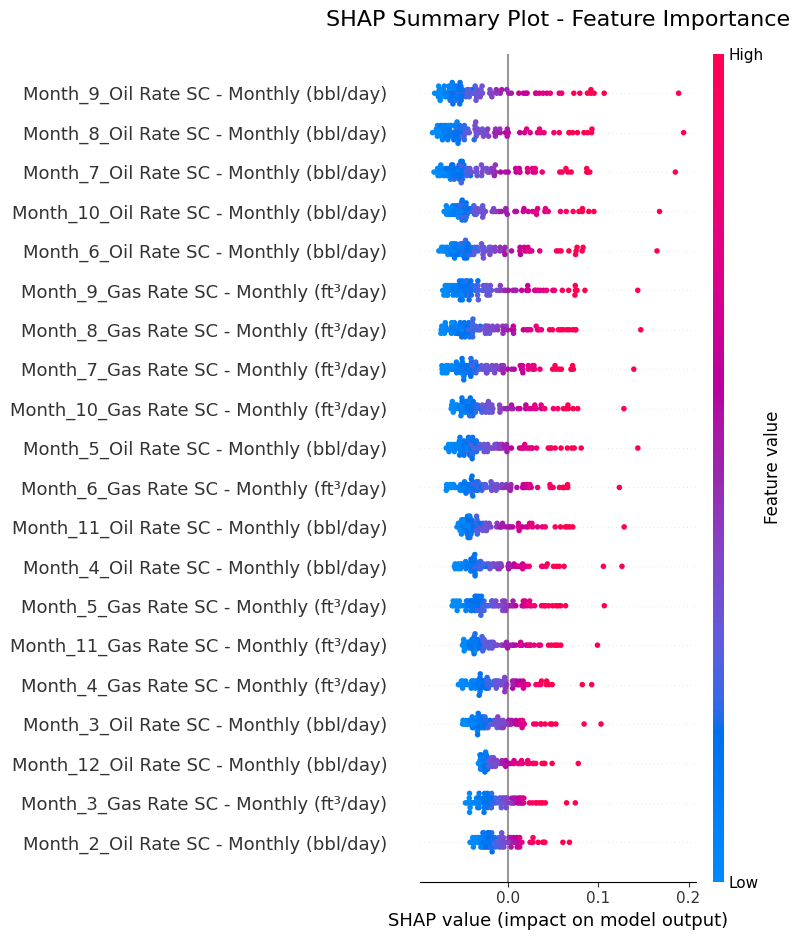

Saved: shap_summary_plot.png



In [39]:
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test_sample_np, 
                  feature_names=X.columns.tolist(),
                  show=False)
plt.title("SHAP Summary Plot - Feature Importance", fontsize=16, pad=20)
plt.tight_layout()
plt.savefig('shap_summary_plot.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved: shap_summary_plot.png\n")

### Shap Bar Plot

C:\Users\tiago\AppData\Local\Temp\ipykernel_3416\3736383407.py:2: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test_sample_np,


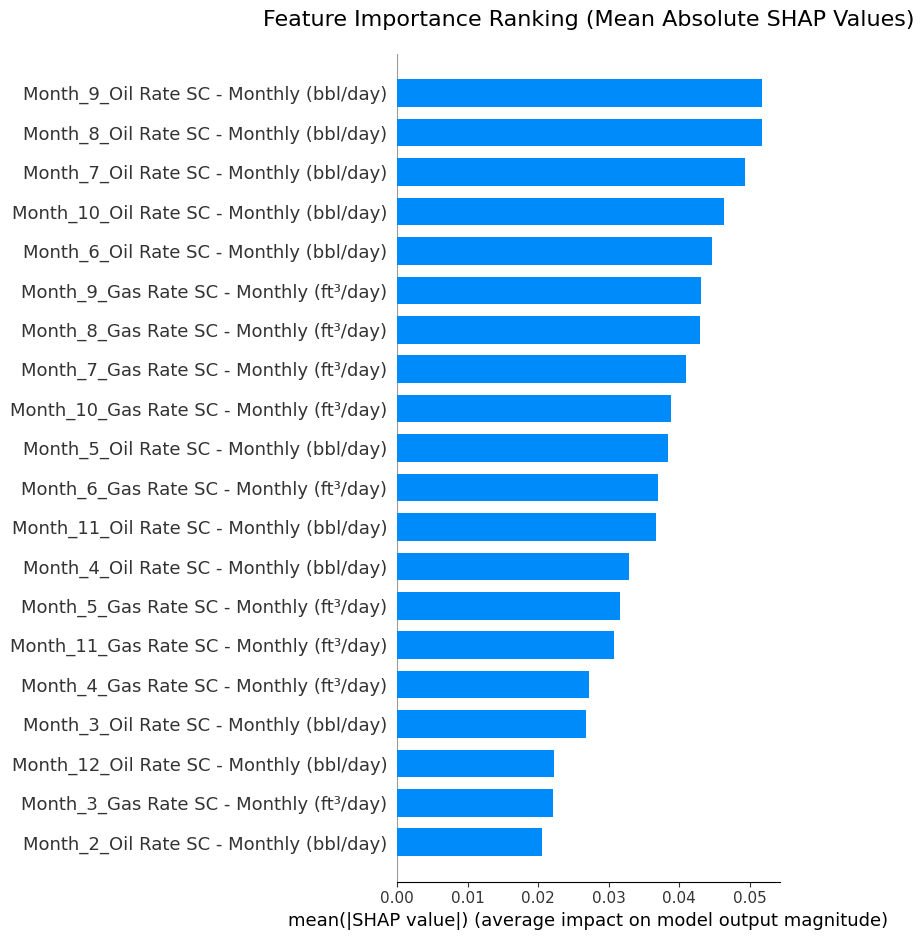

Saved: shap_bar_plot.png



In [40]:
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test_sample_np, 
                  feature_names=X.columns.tolist(),
                  plot_type="bar",
                  show=False)
plt.title("Feature Importance Ranking (Mean Absolute SHAP Values)", fontsize=16, pad=20)
plt.tight_layout()
plt.savefig('shap_bar_plot.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved: shap_bar_plot.png\n")